# Predicción de demanda de taxis

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Condiciones.

1. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Importación de Liberías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression  
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

## Exploración de Datos

In [2]:
data = pd.read_csv('taxi.csv')

In [3]:
display(data.head(10))
data.tail(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


,datetime,num_orders
26486,2018-08-31 22:20:00,48
26487,2018-08-31 22:30:00,41
26488,2018-08-31 22:40:00,34
26489,2018-08-31 22:50:00,34
26490,2018-08-31 23:00:00,30
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


Se observa que el DataFrame está compuesto por dos columnas. Una que es ['datetime'] la cual representa una fecha, y tiene datos de año/mes/día hora/minuto/segundo. La otra columna es nuestro target ['num_orders] que representa la cantidad de viajes que se han realizado a esas horas. También, da la impresión que recorre cierto perdiodo de tiempo, en intervalos de 10 minutos. En método head() nos da las primeras filas mientras quqe el tail() nos da la última. Es obvio que existe un orden en el DataFrame y que el periodo abarca, entonces, del 01/03/2018 a las 00:00 hasta el 31/08/2018 a las 23:50.

Aquí tenemos la cuenta de los datos como número consecutivo como índice, lo que nos dice que existen 26495 entradas. Lo mejor sería quitarlo. Antes de eso, vamos a seguir evaluando de manera rápida el DataFrame.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Como habíamos visto anteriormente existen 26496 entradas (antes 26495 porque el conteo contempla el 0), y hay sólo dos columnas. ['num_orders'] es nuestro target, y es una variable numérica  continua con valores enteros (congruente, porque no hay "medios viajes"). Y ['datetime'] representa una fecha pero como muchos datos en pandas, está como un objeto. Antes se había dicho quitar el conteo consecutivo del índice, y se pondrá esta columna, pero antes se convertirá a formato datetime.

Der manera rápida, podemos decir que no existen valores nulos.
Con el método .nunique() puedo percatarme que, de la misma manera, existen 26496 valores diferentes para ['datetime'] lo que me indica que no existen duplicados implícitos para esta columna. Con duplicated() confirmo que tampoco existen duplicados explícitos.

In [5]:
# nunique() para ver si no hay fechas repetidas
display(data.nunique())
# duplicated() para ver si hay filas repetidas
print(data.duplicated().sum())

datetime      26496
num_orders       81
dtype: int64

0


In [6]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Con el método describe() me puedo hacer un idea de cómo es que de distribuyen de manera general los valores de nuestro target, en cuanto a medidas de tendencia central. El valor promedio es de 14 viajes en ese horario con una desviación de 9.2.

Existen horarios donde no hay ningún viaje, mientras que, el horario con mayor cantidad de viajes ¡alcanza los 119!. La mitad de los datos caen en un valor de 13, lo cual es bastante cercano al promedio.

Con esta información, procedo a modificar el tipo de dato y a establecer el DF final.

In [7]:
# Fecha como datetime
data['datetime'] = pd.to_datetime(data['datetime'])
# data.info()

In [8]:
# Vamos a quitar el índice
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
# Vamos a ordenar por fecha (ya estaban, por si hay un valores que no seguían el patrón)
data.sort_index(inplace=True)
# Hacer un resample de total de viajes por hora
data_hourly = data.resample('H').sum()
data_hourly

C:\Users\usuario\AppData\Local\Temp\ipykernel_23524\307610580.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_hourly = data.resample('H').sum()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [9]:
# Ver si hay horarios con 0 viajes con los datos resampleados
data_hourly.isna().sum()

num_orders    0
dtype: int64

Con todo esto, ya tenemos claro que el DataFrame no cuenta con valores nulos, ni duplicados, y que se de manera satisfactoria tenemos las fechas como índices, además, con el resampleo, de pasó de 26496 a 4416 filas.

## Análisis

Comenzaré con una gráfica sencilla de la distribución de los datos después del resampleo a diferentes niveles.

C:\Users\usuario\AppData\Local\Temp\ipykernel_23524\1702624081.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = data.resample('M').sum()


<Axes: xlabel='datetime'>

<Axes: xlabel='datetime'>

<Axes: xlabel='datetime'>

C:\Users\usuario\AppData\Local\Temp\ipykernel_23524\1702624081.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_hourly = data.resample('H').sum()


<Axes: xlabel='datetime'>

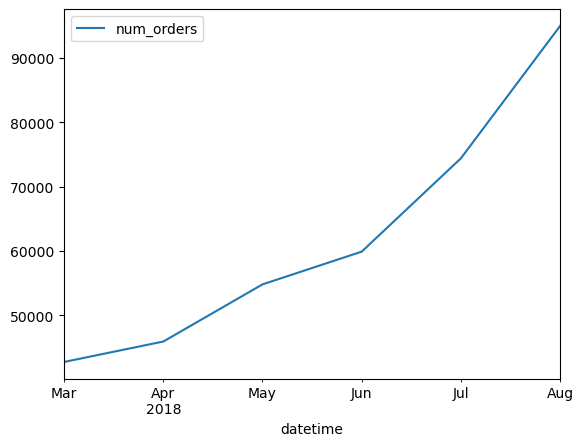

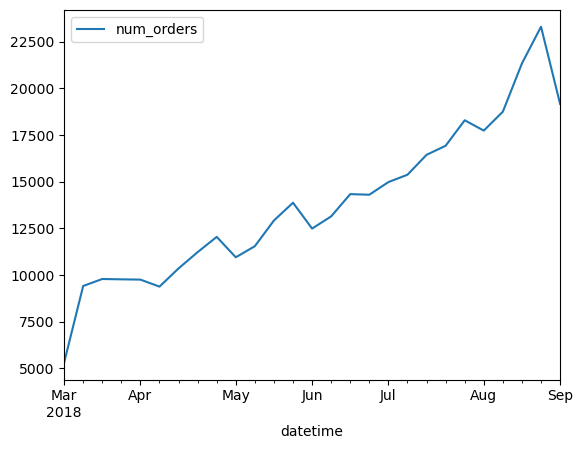

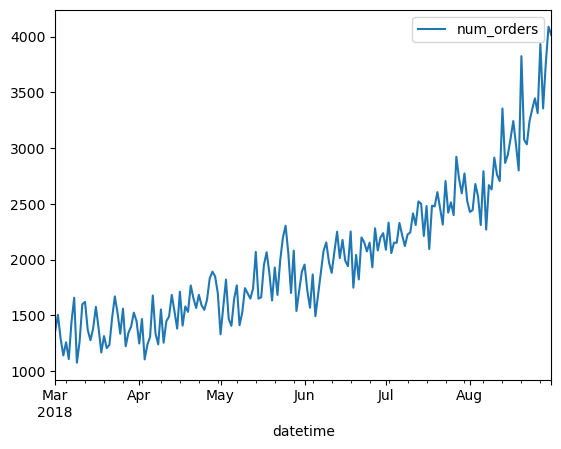

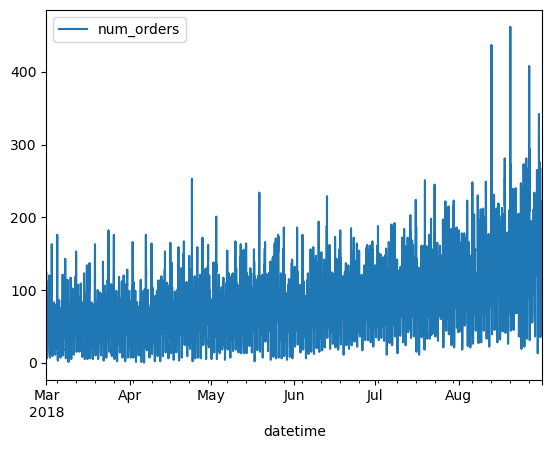

In [10]:
# Resamplear los datos a nivel mensual
data_monthly = data.resample('M').sum()
display(data_monthly.plot())
# Resampleo a nivel semanal
data_weekly = data.resample('W').sum()
display(data_weekly.plot())
# Resampleo a nivel diario
data_daily = data.resample('D').sum()
display(data_daily.plot())
# Resampleo por hora
data_hourly = data.resample('H').sum()
data_hourly.plot()

Hice un resamapleo a nivel mes, semana, diario y por hora. En las cuatro gráficas se puede ver que el la tendencia de los datos es positiva, me refiero, que a lo largo del intervalo de marzo a agosto, la cantidad de viajes va aumentando, y es a partir del mes de junio donde este comportamiento es más evidente. 

In [11]:
# Estadísticas descriptivas de los viajes por hora
data_hourly.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


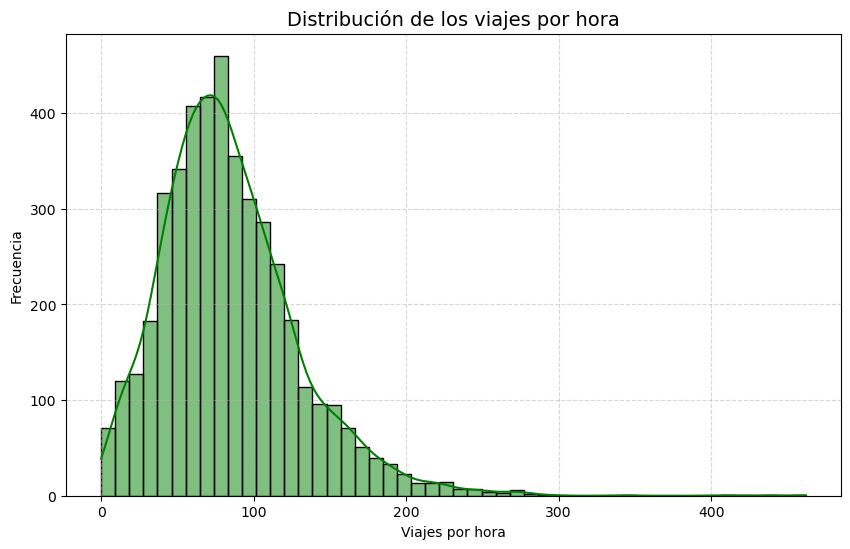

In [12]:
# Histograma de los viajes por hora
plt.figure(figsize=(10,6))
sns.histplot(data=data_hourly, x="num_orders", bins=50, kde=True, color='green')
plt.title("Distribución de los viajes por hora", fontsize=14)
plt.xlabel("Viajes por hora")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

Se hizo estadística descriptiva al resampleo de viajes por hora. Se esquematiza la distribución de ['num_orders'] en un histograma. Es evidente que la mayoría de los valores se concentran en rangos bajos-medios, pero hay una cola hacia la derecha (horas con picos muy altos de pedidos). 

<Axes: title={'center': 'Viajes promedio por hora del día'}, xlabel='datetime'>

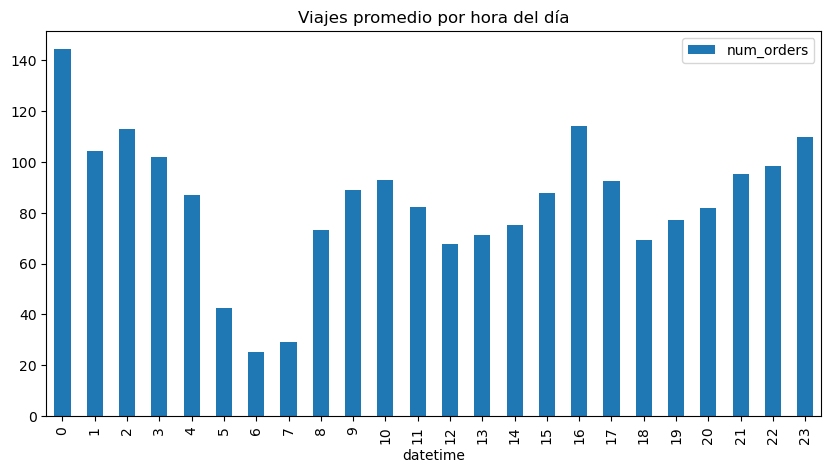

In [13]:
# Patrón de viajes por hora del día
hourly_pattern = data_hourly.groupby(data_hourly.index.hour).mean()
hourly_pattern.plot(kind="bar", figsize=(10,5), title="Viajes promedio por hora del día")

<Axes: title={'center': 'Viajes promedio por día de la semana'}, xlabel='datetime'>

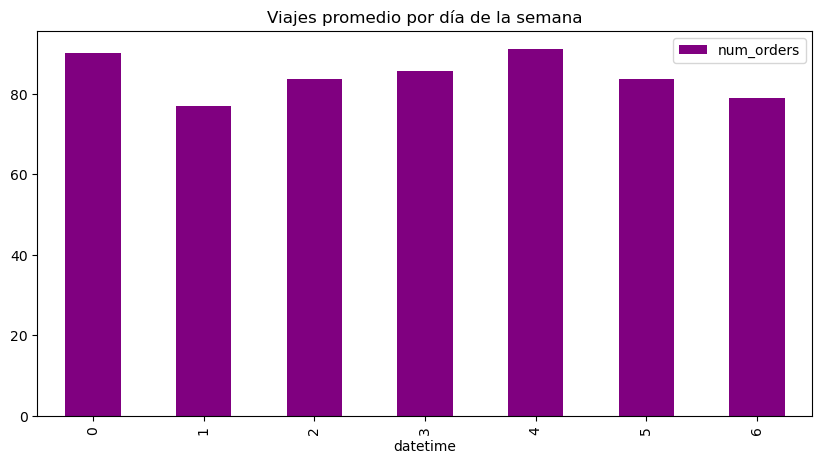

In [14]:
# Patrón de viajes por día de la semana
weekly_pattern = data_hourly.groupby(data_hourly.index.dayofweek).mean()
weekly_pattern.plot(kind="bar", figsize=(10,5), title="Viajes promedio por día de la semana", color='purple')

<Axes: title={'center': 'Viajes promedio por mes'}, xlabel='datetime'>

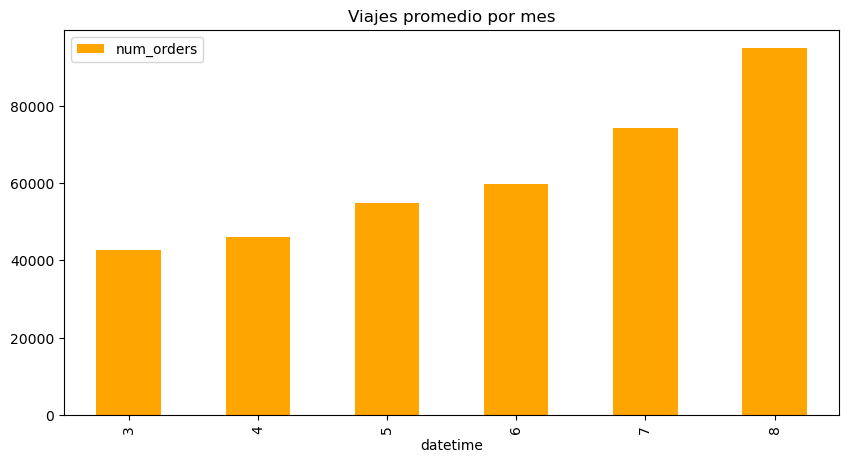

In [15]:
# Patrón de viajes por mes
monthly_pattern = data_monthly.groupby(data_monthly.index.month).mean()
monthly_pattern.plot(kind="bar", figsize=(10,5), title="Viajes promedio por mes", color='orange')

Estas tres gráficas anteriores refuerzan los patrones que se habían observado:
* Existe un incremento de viajes a lo largo del periodo de meses.
* Los días de las semana donde hay más viajes son lunes y viernes, y el martes es el día con menor frecuencia.
* La gente viaja más de madrugada, desde las 21:00 alcanzando un pico a las 00:00. Las horas menos preferidas para viajar son de las 5 a las 7 de la mañana.

In [16]:
# Media móvil para los datos por hora
data_hourly['media_movil_por_hora'] = data_hourly['num_orders'].rolling(24).mean()
data_hourly['media_movil_semanal'] = data_hourly['num_orders'].rolling(168).mean()
data_hourly

,num_orders,media_movil_por_hora,media_movil_semanal
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN
...,...,...,...
2018-08-31 19:00:00,136,167.541667,154.434524
2018-08-31 20:00:00,154,168.041667,154.285714
2018-08-31 21:00:00,159,166.416667,154.244048


In [17]:
data_hourly.corr()

,num_orders,media_movil_por_hora,media_movil_semanal
num_orders,1.000000,0.575594,0.555788
media_movil_por_hora,0.575594,1.000000,0.949959
media_movil_semanal,0.555788,0.949959,1.000000


Se hizo una media móvil con ventana de las 24 horas del día, y otra con una ventana que corresponde a las horas semanales (24*7=168). Al escoger una ventana tan grande, puedo ver que tengo muchas filas que ahora tienen valores ausentes, y esta media se comporta de una manera mucho más estática que la media móvil de una ventana más pequeña (no se parece nada a los datos reales cuando fluctuan). Se hizo una matriz de correlación y existe una correlación positiva de 0.94 entre la media movil por hora y por semana. Con esto, me retracto de añadir el feature de la media semana y por el momento sólo conservaré la media movil "por hora".

In [18]:
data_hourly.drop(columns=['media_movil_semanal'], inplace=True)

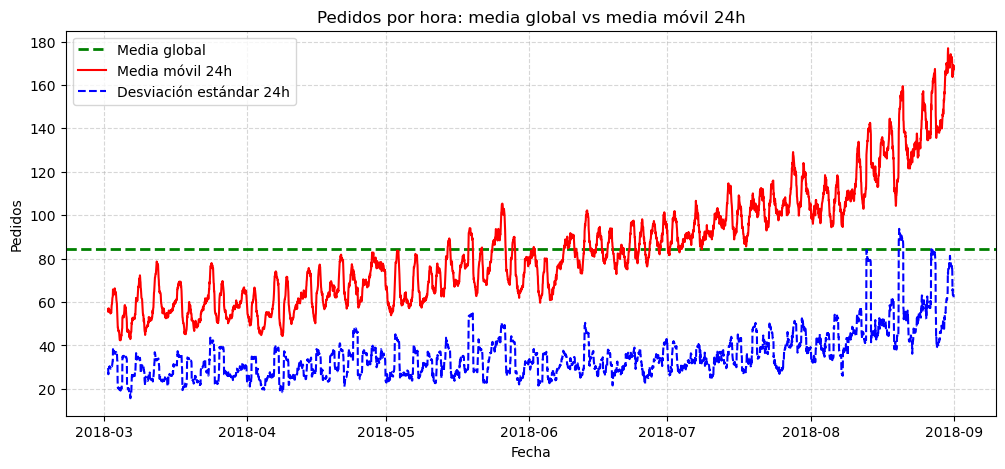

In [19]:
# Gráfico de la media móvil y la media global.
plt.figure(figsize=(12,5))
mean_value = data_hourly['num_orders'].mean()
std = data_hourly['num_orders'].rolling(24).std()
plt.axhline(y=mean_value, color='green', linestyle='--', linewidth=2, label='Media global')
plt.plot(data_hourly['num_orders'].rolling(24).mean(), color='red', label='Media móvil 24h')
plt.plot(std, color='blue', linestyle='--', label='Desviación estándar 24h')
plt.title("Pedidos por hora: media global vs media móvil 24h")
plt.xlabel("Fecha"); plt.ylabel("Pedidos")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

Se hace un decompose de el número de viajes en data_hourly:

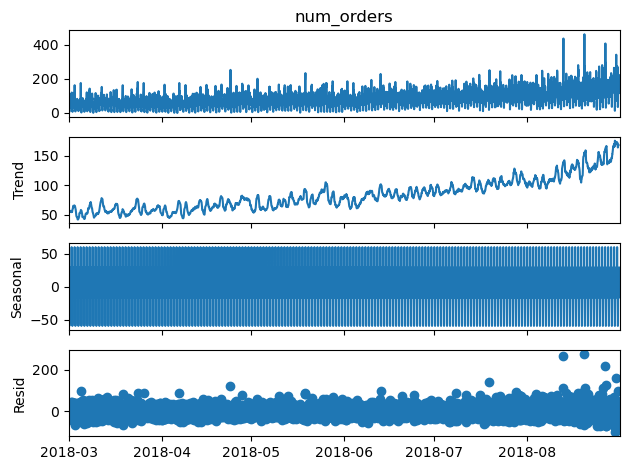

In [20]:
data_hourly_decomposed = seasonal_decompose(data_hourly['num_orders'], model='additive', period=24).plot()

Como se había observado anteriormente, el valor medio de los datos sí cambian con relación al tiempo (incremento de los viajes de marzo a agosto, incrementándose este aumento a partir de junio) no corresponden a datos estacionarios. La tendencia, al suavizar, se ve claramente que desde marzo hasta agosto la demanda de taxis aumenta. La estacionalidad presenta un patrón lo que pudiera indicar una estacionalidad A NIVEL DIARIO, NO MENSUAL. Los residuos representan la parte de la serie que no se explica ni por la tendencia ni por la estacionalidad por lo queu se ven algunos puntos disperos que esqumatizan ruido, sobre todo, picos anómalos (outliers) en agosto.

Todo esto, justifica la construcción de lags y rolling features en el siguiente paso.

## Formación de los Modelos y Prueba

In [21]:
# Establecer topes
MAX_LAG = 24
ROLL = 24

# # Función para creación de features
def feature_engineer(df, max_lag=MAX_LAG, rolling_mean_size=ROLL):
    df_output = df.copy()
    df_output['year'] = df_output.index.year
    df_output['month'] = df_output.index.month
    df_output['day'] = df_output.index.day
    df_output['day_of_week'] = df_output.index.dayofweek
    df_output['hour'] = df_output.index.hour

    for lag in range(1, max_lag + 1):
        df_output[f'lag_{lag}'] = df_output['num_orders'].shift(lag)
    df_output['rolling_mean'] = df_output['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df_output

# Split temporal sobre los datos CRUDOS (no transformados)
split_idx = int(len(data_hourly) * 0.9)
train_raw = data_hourly.iloc[:split_idx].copy()
test_raw  = data_hourly.iloc[split_idx:].copy()

# Features por separado para evitar fuga
train_fe = feature_engineer(train_raw).dropna()
test_fe  = feature_engineer(test_raw).dropna()

# Alinear test para evitar NaNs y Data Leakage
test_fe = test_fe.iloc[MAX_LAG:]

# Dividir en conjuntos de entrenamiento y prueba
X_train = train_fe.drop(columns=['num_orders'])
y_train = train_fe['num_orders']
X_test  = test_fe.drop(columns=['num_orders'])
y_test  = test_fe['num_orders']  

**REGRESIÓN LINEAL**

In [22]:
forbidden = ['media_movil_por_hora']
X_train = X_train.drop(columns=[c for c in forbidden if c in X_train.columns])
X_test  = X_test.drop(columns=[c for c in forbidden if c in X_test.columns])

In [23]:
# Modelo
lr = LinearRegression()
# Entrenamiento
lr.fit(X_train, y_train)
# Predicciones
pred_train = lr.predict(X_train)
pred_test  = lr.predict(X_test)
# Evaluación
print("RMSE train:", root_mean_squared_error(y_train, pred_train))
print("RMSE test :", root_mean_squared_error(y_test,  pred_test))

RMSE train: 25.699174244212355
RMSE test : 46.200453217356575


**RANDOM FOREST REGRESSOR**

In [24]:
# Modelo Random Forest Regressor
random_forest_reg = RandomForestRegressor(n_jobs=-1, random_state=17)

# Definición de hiperparámetros para GridSearchCV
param_grid_rfg = {
    "n_estimators": [50, 100],   
    "max_depth": [None, 10, 20],       
    "min_samples_split": [2, 5, 10],   
    "min_samples_leaf": [1, 2]      
}

# Split temporal para la validación cruzada
tscv_rfr = TimeSeriesSplit(n_splits=3)

# GridSearchCV para encontrar la mejor combinación de hiperparámetros
grid_search = GridSearchCV(
    estimator=random_forest_reg,
    param_grid=param_grid_rfg,
    scoring="neg_root_mean_squared_error",  
    cv=tscv_rfr,           
    verbose=0
)

# Ejecución de GridSearchCV
grid_search.fit(X_train, y_train)
print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [25]:
# Mejor combinación encontrada
print("Mejor RMSE CV:", -grid_search.best_score_)

random_forest_reg = RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=2, 
    min_samples_split=5, 
    n_estimators=100,
    n_jobs=-1
)

# Evaluar en test
best_rfg = grid_search.best_estimator_
y_pred_rfg = best_rfg.predict(X_test)
rfg_rmse = root_mean_squared_error(y_test, y_pred_rfg)
print("RMSE en test con mejor RandomForestRegressor:", rfg_rmse)

Mejor RMSE CV: 26.744280172670866
RMSE en test con mejor RandomForestRegressor: 44.904434428975975


**Graddient Boosting Regressor**

In [26]:
# Modelo
gbr = GradientBoostingRegressor(random_state=17)

# Definición de hiperparámetros para GridSearchCV
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.1, 0.05, 0.02],
    "max_depth": [2, 3, 4],
    "subsample": [1.0, 0.8],
    "max_features": [None, "sqrt"]
}

# TimeSeriesSplit para validación cruzada
tscv = TimeSeriesSplit(n_splits=3)

# GridSearchCV para encontrar la mejor combinación de hiperparámetros
grid_gbr = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    verbose=0,
    n_jobs=-1
)

In [27]:
# Ejecución de GridSearchCV
grid_gbr.fit(X_train, y_train)
print("Mejores params:", grid_gbr.best_params_)

# Mejor combinación encontrada
print("Mejor RMSE CV:", -grid_gbr.best_score_)

# Aplicar hiperparámetros óptimos y evaluar en test
gbr = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=3,
    max_features=None,
    n_estimators=100,
    subsample=0.8,
    random_state=17
)

best_gbr = grid_gbr.best_estimator_
y_pred_gbr = best_gbr.predict(X_test)
rmse_gbr = root_mean_squared_error(y_test, y_pred_gbr)
print("RMSE en test con mejor GradientBoostingRegressor:", rmse_gbr)

Mejores params: {'learning_rate': 0.05, 'max_depth': 4, 'max_features': None, 'n_estimators': 300, 'subsample': 0.8}
Mejor RMSE CV: 25.847520432381142
RMSE en test con mejor GradientBoostingRegressor: 47.244104924408866


| Modelo           | RMSE (test) |
| ---------------- | ----------- |
| LinearRegression | 47.08132    |
| RandomForest     | 44.90443    |
| GradientBoosting | 47.24410    |


## Conclusiones Generales

El objetivo del proyecto era predecir el número de pedidos de taxi para la siguiente hora, con la condición de que el **RMSE en el conjunto de prueba fuera ≤ 48**.  

Se probaron diferentes modelos: **LinearRegression**, **RandomForest** y **GradientBoosting**. Los resultados mostraronn
:  

- El modelo con mejor desempeño fue **RandomForestRegressor**, alcanzando un RMSE de **44.90443**.  
- Los demás modelos obtuvieron valores de RMSE muy cercanos entre ellos y cercanos al umbral límite de la métrica evaluadora del modelo.  
- En general, todos los modelos cumplieron con el criterio de evaluación, pero RandomFOrestRegressor lo hizo un tanto mejor.

Del análisis exploratorio se observó que la serie de pedidos tiene un comportamiento **estocástico**, sin una estacionalidad clara, aunque se detectaron diferencias en la cantidad de pedidos según la hora del día y el día de la semana.  